In [1]:
import keras

Using TensorFlow backend.


In [2]:
keras.__version__

'2.3.0'

In [5]:
keras.backend.tensorflow_backend.get_session()

In [6]:
keras.backend.tensorflow_backend.tf_keras_backend._SESSION.session

In [180]:
import shap
from shap.common import convert_name
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D  

def compute_bounds(xmin, xmax, xv):
    """ Handles any setting of xmax and xmin.
    
    Note that we handle None, float, or "percentile(float)" formats.
    """
    
    if xmin is not None or xmax is not None:
        if type(xmin) == str and xmin.startswith("percentile"):
            xmin = np.nanpercentile(xv, float(xmin[11:-1]))
        if type(xmax) == str and xmax.startswith("percentile"):
            xmax = np.nanpercentile(xv, float(xmax[11:-1]))

        if xmin is None or xmin == np.nanmin(xv):
            xmin = np.nanmin(xv) - (xmax - np.nanmin(xv))/20
        if xmax is None or xmax == np.nanmax(xv):
            xmax = np.nanmax(xv) + (np.nanmax(xv) - xmin)/20
            
    return (xmin, xmax)

def partial_dependence_plot(ind, model, features, xmin="percentile(0)", xmax="percentile(100)",
                            npoints=None, nsamples=100, feature_names=None, hist=True,
                            ylabel=None, ice=False, opacity=None, linewidth=None, show=True):
    
    # convert from DataFrames if we got any
    if str(type(features)).endswith("'pandas.core.frame.DataFrame'>"):
        if feature_names is None:
            feature_names = features.columns
        features = features.values
        
    if feature_names is None:
        feature_names = ["Feature %d" % i for i in range(features.shape[1])]
    
    # this is for a 1D partial dependence plot
    if type(ind) is not tuple:
        ind = convert_name(ind, None, feature_names)
        xv = features[:,ind]
        xmin, xmax = compute_bounds(xmin, xmax, xv)
        npoints = 100 if npoints is None else npoints
        xs = np.linspace(xmin, xmax, npoints)
        
        features_tmp = features.copy()
        if not ice:
            vals = np.zeros(npoints)
            for i in range(npoints):
                features_tmp[:,ind] = xs[i]
                vals[i] = model(features_tmp).mean()
            if linewidth is None:
                linewidth = 2
            if opacity is None:
                opacity = 1
        else:
            vals = np.zeros((npoints, features.shape[0]))
            for i in range(npoints):
                features_tmp[:,ind] = xs[i]
                vals[i,:] = model(features_tmp)
            if linewidth is None:
                linewidth = 1
            if opacity is None:
                opacity = 0.5
        

        
            
        # the histogram of the data
        fig, ax1 = pl.subplots()

        ax1.plot(xs, vals, color=shap.plots.colors.blue_rgb, linewidth=linewidth, alpha=opacity)

        ax2 = ax1.twinx()

        if hist:
            n, bins, patches = ax2.hist(xv, 50, density=False, facecolor='black', range=(xmin, xmax))

        ax2.set_ylim(0,features.shape[0])#ax2.get_ylim()[0], ax2.get_ylim()[1] * 4)
        ax1.set_xlabel(feature_names[ind], fontsize=13)
        if ylabel is None:
            if not ice:
                ylabel = "E[f(x) | "+ str(feature_names[ind]) + "]"
            else:
                ylabel = "f(x) | "+X_trainb.columns[find]
        ax1.set_ylabel(ylabel, fontsize=13)
        ax1.xaxis.set_ticks_position('bottom')
        ax1.yaxis.set_ticks_position('left')
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.tick_params(labelsize=11)

        ax2.xaxis.set_ticks_position('bottom')
        ax2.yaxis.set_ticks_position('left')
        ax2.yaxis.set_ticks([])
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        if show:
            pl.show()
        else:
            return fig,ax1
        
        
    # this is for a 2D partial dependence plot
    else:
        ind0 = convert_name(ind[0], None, feature_names)
        ind1 = convert_name(ind[1], None, feature_names)
        xv0 = features[:,ind0]
        xv1 = features[:,ind1]
        
        xmin0 = xmin[0] if type(xmin) is tuple else xmin
        xmin1 = xmin[1] if type(xmin) is tuple else xmin
        xmax0 = xmax[0] if type(xmax) is tuple else xmax
        xmax1 = xmax[1] if type(xmax) is tuple else xmax
        
        xmin0, xmax0 = compute_bounds(xmin0, xmax0, xv0)
        xmin1, xmax1 = compute_bounds(xmin1, xmax1, xv1)
        npoints = 20 if npoints is None else npoints
        xs0 = np.linspace(xmin0, xmax0, npoints)
        xs1 = np.linspace(xmin1, xmax1, npoints)
        
        features_tmp = features.copy()
        x0 = np.zeros((npoints, npoints))
        x1 = np.zeros((npoints, npoints))
        vals = np.zeros((npoints, npoints))
        for i in range(npoints):
            for j in range(npoints):
                features_tmp[:,ind0] = xs0[i]
                features_tmp[:,ind1] = xs1[j]
                x0[i, j] = xs0[i]
                x1[i, j] = xs1[j]
                vals[i, j] = model(features_tmp).mean()
                
        fig = pl.figure()
        ax = fig.add_subplot(111, projection='3d')


#         x = y = np.arange(-3.0, 3.0, 0.05)
#         X, Y = np.meshgrid(x, y)
#         zs = np.array(fun(np.ravel(X), np.ravel(Y)))
#         Z = zs.reshape(X.shape)

        ax.plot_surface(x0, x1, vals, cmap=shap.plots.colors.red_blue_transparent)

        ax.set_xlabel(feature_names[ind0], fontsize=13)
        ax.set_ylabel(feature_names[ind1], fontsize=13)
        ax.set_zlabel("E[f(x) | "+ str(feature_names[ind0]) + ", "+ str(feature_names[ind1]) + "]", fontsize=13)

        if show:
            pl.show()
        else:      
            return fig, ax


In [1]:
import xgboost
import shap

# load JS visualization code to notebook
#shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model, X, feature_dependence="independent")
shap_values = explainer.shap_values(X)

In [354]:
explainer = shap.TreeExplainer(model, X, feature_dependence="independent")
shap_values = explainer.shap_values(X)

In [46]:
import scipy.special
import numpy as np
import itertools

def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def shapley_kernel(M,s):
    if s == 0 or s == M:
        return 10000
    return (M-1)/(scipy.special.binom(M,s)*s*(M-s))

def f(X):
    np.random.seed(0)
    beta = np.random.rand(X.shape[-1])
    return np.dot(X,beta) + 10

def kernel_shap(f, x, reference, M):
    X = np.zeros((2**M,M+1))
    X[:,-1] = 1
    weights = np.zeros(2**M)
    V = np.zeros((2**M,M))
    for i in range(2**M):
        V[i,:] = reference

    ws = {}
    for i,s in enumerate(powerset(range(M))):
        s = list(s)
        V[i,s] = x[s]
        X[i,s] = 1
        ws[len(s)] = ws.get(len(s), 0) + shapley_kernel(M,len(s))
        weights[i] = shapley_kernel(M,len(s))
    y = f(V)
    tmp = np.linalg.inv(np.dot(np.dot(X.T, np.diag(weights)), X))
    return np.dot(tmp, np.dot(np.dot(X.T, np.diag(weights)), y))

M = 4
np.random.seed(1)
x = np.random.randn(M)
reference = np.zeros(M)
phi = kernel_shap(f, x, reference, M)
base_value = phi[-1]
shap_values = phi[:-1]

print("  reference =", reference)
print("          x =", x)
print("shap_values =", shap_values)
print(" base_value =", base_value)
print("   sum(phi) =", np.sum(phi))
print("       f(x) =", f(x))

  reference = [0. 0. 0. 0.]
          x = [ 1.62434536 -0.61175641 -0.52817175 -1.07296862]
shap_values = [ 0.89146267 -0.43752168 -0.31836259 -0.58464256]
 base_value = 9.999999999999996
   sum(phi) = 9.55093584211863
       f(x) = 9.55093584213122


In [146]:
def shapley_weight(M, s):
    return 1 / (scipy.special.binom(M, s) * (M-s))

def shapley_interaction_weight(M, s):
    return 1 / (scipy.special.binom(M-1, s) * (M-s-1))

In [168]:
import scipy.special
import numpy as np
import itertools

def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

class BruteForceExplainer(object):
    def __init__(self, masked_evaluator):
        self.f = masked_evaluator
        
    def shap_values(self, X):
        M = X.shape[1]
        shap_values = np.zeros(X.shape)
        for find in range(M):
            for i,s in enumerate(powerset(set(range(M)).difference([find]))):
                w = shapley_weight(M, len(s))
                shap_values[:,find] += w * (self.f(X, tuple(set(s).union([find]))) - self.f(X, s))
        return shap_values
    
    def shap_interaction_values(self, X):
        M = X.shape[1]
        shap_interaction_values = np.zeros((X.shape[0], X.shape[1], X.shape[1]))
        for find1 in tqdm(range(M)):
            for find2 in range(M):
                if find1 == find2:
                    continue
                for i,s in enumerate(powerset(set(range(M)).difference([find1, find2]))):
                    w = shapley_interaction_weight(M, len(s))
                    shap_interaction_values[:,find1,find2] += 0.5 * w * (
                        self.f(X, tuple(set(s).union([find1,find2])))
                        - self.f(X, tuple(set(s).union([find1])))
                        - self.f(X, tuple(set(s).union([find2])))
                        + self.f(X, s)
                    )

        return shap_interaction_values

In [181]:
def f(x):
    return model.predict(xgboost.DMatrix(x), validate_features=False)


In [170]:
def masker(X, s):
    Xtmp = X.copy()
    sinv = tuple(set(range(X.shape[1])).difference(s))
    Xtmp[:,sinv] = 0
    return model.predict(xgboost.DMatrix(Xtmp), validate_features=False)
e = BruteForceExplainer(masker)
svb = e.shap_values(X.values[2:3,:])

In [171]:
svb_int = e.shap_interaction_values(X.values[2:3,:])


100%|██████████| 13/13 [01:43<00:00,  7.80s/it]

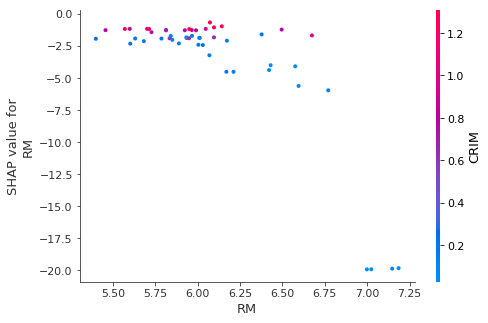

In [358]:
shap.dependence_plot(5, (shap_values[:50] - (shap_interaction_values*2).sum(2)), X.iloc[:50])

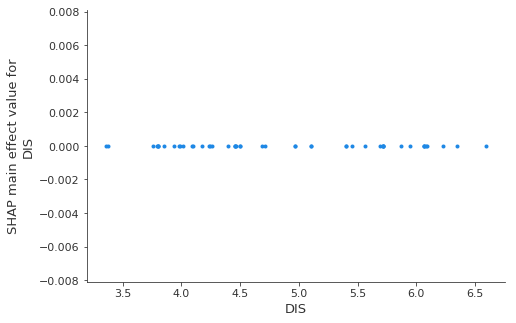

In [350]:
shap.dependence_plot((7,7), shap_interaction_values, X.iloc[:50])

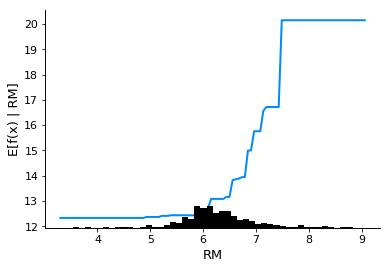

In [182]:
partial_dependence_plot(5, f, X)

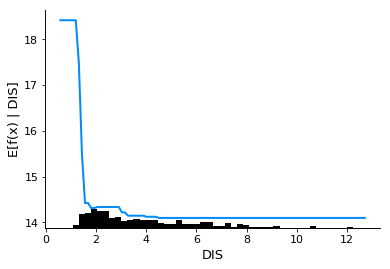

In [184]:
partial_dependence_plot(7, f, X)

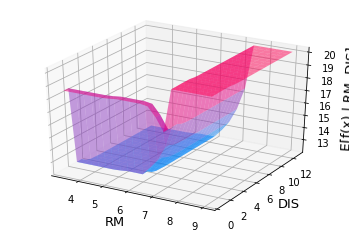

In [185]:
partial_dependence_plot((5,7), f, X)

In [189]:
svb

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.77318401,  0.15298542, -6.61430735,  0.02947362,  0.        ,
         0.        ,  0.65622092,  0.        ]])

In [189]:
svb_int

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.77318401,  0.15298542, -6.61430735,  0.02947362,  0.        ,
         0.        ,  0.65622092,  0.        ]])

In [186]:
X.iloc[2]

CRIM         0.02729
ZN           0.00000
INDUS        7.07000
CHAS         0.00000
NOX          0.46900
RM           7.18500
AGE         61.10000
DIS          4.96710
RAD          2.00000
TAX        242.00000
PTRATIO     17.80000
B          392.83000
LSTAT        4.03000
Name: 2, dtype: float64

[<matplotlib.lines.Line2D at 0x1c1e7ff080>]

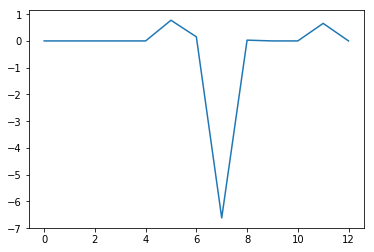

In [174]:
plt.plot(svb[0])

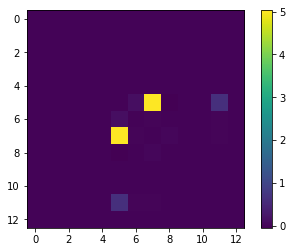

In [190]:
plt.imshow(svb_int[0])
plt.colorbar()

In [200]:
def mobius(v, S):
    out = 0
    for T in powerset(S):
        if (len(S) - len(T)) % 2 == 0:
            out += v(T)
        else:
            out -= v(T)
    return out

In [238]:
def comobius(v, S, N):
    out = 0
    for T in powerset(S):
        
        if (len(S) - len(T)) % 2 == 0:
            out += v(N.difference(T))
        else:
            out -= v(N.difference(T))
    return out

In [236]:
for T in powerset([1,2,3]):
    print(T)
    break

()


In [198]:
x = X.values[2:3,:]

In [262]:
def v(S):
    return masker(x, S)[0]

In [ ]:
GO0CVVNMPUUYHGFDSA bbnmk;\;';"'ppp[]]\\\'"'uuu

In [300]:
4.971189498901367 - 6.550333023071289

-1.5791435241699219

In [304]:
def singleton_weights(dividends, M):
    out = np.zeros(M)
    for S in dividends:
        if len(S) == 1:
            out[S[0]] = dividends[S]
    return out

In [306]:
singleton_weights(mobius_sets, X.shape[1]).sum()

-16.700807571411133

In [307]:
singleton_weights(comobius_sets, X.shape[1]).sum()

-6.897960662841797

In [253]:
count = 0
comobius_sets = {}
N = set(range(X.shape[1]))
for S in powerset(range(X.shape[1])):
    if count > 50:
        break
    mval = comobius(v, S, N)
    
    if mval != 0:
        count += 1
        comobius_sets[S] = mval
        print()
        print("v("+str(N.difference(S))+"]", v(N.difference(S)))
        print("m("+str(S)+"]", mval)


v({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}] 21.424852
m(()] 21.42485237121582

v({0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12}] 14.874519
m((5,)] -6.550333023071289

v({0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12}] 21.027159
m((6,)] -0.3976936340332031

v({0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12}] 22.891073
m((7,)] 1.4662208557128906

v({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12}] 20.008698
m((11,)] -1.4161548614501953

v({0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12}] 14.874519
m((5, 6)] 0.3976936340332031

v({0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12}] 26.427296
m((5, 7)] 10.086555480957031

v({0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12}] 14.697678
m((5, 8)] -0.17684173583984375

v({0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12}] 14.874519
m((5, 11)] 1.4161548614501953

v({0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12}] 22.664835
m((6, 7)] 0.17145538330078125

v({0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12}] 19.81843
m((6, 11)] 0.2074260711669922

v({0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12}] 21.682344
m((7, 11)] 0.2074260711669922

v({0, 1, 2, 3, 4, 8, 9, 10, 11

In [273]:
def equal_share_values(inds, dividends):
    out = 0
    if type(inds) is tuple and len(inds) == 2:
        i,j = inds
        for S in dividends:
            if i in S and j in S:
                out += dividends[S] / scipy.special.binom(len(S),2)
    else:
        i = inds
        for S in dividends:
            if i in S:
                out += dividends[S] / len(S)
    return out

In [270]:
equal_share_values(5, comobius_sets)

-0.7731839815775553

In [271]:
equal_share_values(5, mobius_sets)

0.7731839815775554

In [287]:
v(list(range(X.shape[1]))) - v(())

-5.0024433

In [303]:
svb.sum() - svb_int[0].sum() / 2

-10.902135586141412

In [308]:
sum(mobius_sets.values())

21.42485237121582

In [312]:
svb_int.sum() / 2

5.899692206891814

In [346]:
svb[0,5] - (svb_int[0,5]*2).sum()

-10.748338798002806

In [316]:
svb_int2.sum() / 2

11.698364257812502

In [328]:
svb[0,5] - svb_int_mobius[0,5,:].sum() / 2

-4.971189465878222

In [459]:
svb[0,5] - svb_int_mobius[0,5,:].sum() / 2 -svb[0,5] - svb_int_comobius[0,5,:].sum() / 2

-11.521522521972656

In [460]:
svb_int[0,5,:].sum() * 2

11.521522812603507

In [446]:
svb_int_mobius[0,5,:].sum() / 2

5.744373480478924

In [448]:
svb_int_comobius[0,5,:].sum() / 2

5.777149041493733

In [330]:
-svb[0,5] - svb_int_comobius[0,5,:].sum() / 2

-6.550333056094435

In [458]:
2 * svb[0,5] - (svb_int_mobius[0,5,:].sum() / 2 + svb_int_comobius[0,5,:].sum() / 2)

-9.975154492771253

In [449]:
mv.sum()

5.760761260986328

In [441]:
mv = (svb_int_mobius[0,5,:] / 2 + svb_int_comobius[0,5,:] / 2) / 2

In [445]:
svb[0,5] - mv.sum()

-4.9875772463856265

In [443]:
svb[0,5] - svb_int[0,5].sum()

-4.987577391701052

In [341]:
6.550333056094435 - (-4.971189465878222)

11.521522521972656

In [338]:
(6.55033305 + 4.9711894) / 2

5.7607612249999995

In [342]:
(svb_int_mobius[0,5,:].sum() / 2 + svb_int_comobius[0,5,:].sum() / 2)

11.521522521972656

In [339]:
(svb[0,5] - svb[0,5]) / 2 - (svb_int_mobius[0,5,:].sum() / 2 + svb_int_comobius[0,5,:].sum() / 2) / 2

-5.760761260986328

In [340]:
svb_int[0,5,:].sum()

5.760761406301754

In [335]:
svb[0,5] - svb_int[0,5,:].sum()

-4.987577391701052

In [327]:
tmp = (svb_int_mobius + svb_int_comobius) / 2
np.abs(tmp / 2 - svb_int).sum()

3.0083477418202387e-07

In [440]:
tmp = (svb_int_mobius + svb_int_comobius) / 2
np.abs(tmp / 2 - svb_int).sum()

3.0083477418202387e-07

In [317]:
singleton_weights(mobius_sets, X.shape[1]).sum() + svb_int_mobius.sum() / 2

-5.002443313598631

In [317]:
singleton_weights(mobius_sets, X.shape[1]).sum() + svb_int_mobius.sum() / 2

-5.002443313598631

In [301]:
svb[0,5] - svb_int[0,5,:].sum() / 2

-2.107196688550175

In [321]:
svb_int_mobius = np.zeros(svb_int.shape)
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        if i == j: continue
        svb_int_mobius[0,i,j] = equal_share_values((i,j), mobius_sets)

In [322]:
svb_int_comobius = np.zeros(svb_int.shape)
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        if i == j: continue
        svb_int_comobius[0,i,j] = equal_share_values((i,j), comobius_sets)

In [275]:
equal_share_values((5,7), mobius_sets), equal_share_values((5,7), comobius_sets)

(10.055575370788576, 10.05377991994222)

In [281]:
equal_share_values((5,11), mobius_sets), equal_share_values((5,11), comobius_sets)

(1.2432998021443684, 1.312441825866699)

In [279]:
tmp1 = (equal_share_values((5,7), mobius_sets) + equal_share_values((5,7), comobius_sets)) / 2
tmp2 = shap_interaction_values[2,5,7]
print(tmp1)
print(tmp2)

10.054677645365398
10.054677568376064


In [280]:
tmp1 = (equal_share_values((5,11), mobius_sets) + equal_share_values((5,11), comobius_sets)) / 2
tmp2 = shap_interaction_values[2,5,11]
print(tmp1)
print(tmp2)

1.2778708140055337
1.2778721787035465


In [263]:
count = 0
mobius_sets = {}
for S in powerset(range(X.shape[1])):
    
    if count > 50:
        break
    mval = mobius(v, S)
    if mval != 0:
        count += 1
        mobius_sets[S] = mval
        print()
        print("v("+str(S)+"]", v(S))
        print("m("+str(S)+"]", mval)


v(()] 26.427296
m(()] 26.427295684814453

v((5,)] 21.456106
m((5,)] -4.971189498901367

v((7,)] 14.697678
m((7,)] -11.729618072509766

v((5, 6)] 21.682344
m((5, 6)] 0.22623825073242188

v((5, 7)] 19.81843
m((5, 7)] 10.091941833496094

v((5, 11)] 22.664835
m((5, 11)] 1.2087287902832031

v((7, 8)] 14.874519
m((7, 8)] 0.17684173583984375

v((5, 6, 7)] 20.008698
m((5, 6, 7)] -0.03597068786621094

v((5, 7, 8)] 19.81843
m((5, 7, 8)] -0.17684173583984375

v((5, 6, 7, 11)] 21.424852
m((5, 6, 7, 11)] 0.2074260711669922


In [247]:
(-4.971189498901367 -6.550333023071289) / 2

-5.760761260986328

In [213]:
svb

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.77318401,  0.15298542, -6.61430735,  0.02947362,  0.        ,
         0.        ,  0.65622092,  0.        ]])

In [223]:
svb_int[0,5,7] * 2

10.054677900625393

In [250]:
svb_int[0,7,5] * 2

10.054677900625393

In [230]:
shap_interaction_values[2,5,7]

10.054677568376064

In [248]:
svb[0,5] - svb_int[0,5,:].sum()

-4.987577391701052

In [249]:
svb_int[0,5,5]

0.0

In [215]:
-4.971189498901367 + 0.22623825073242188/2 + 10.091941833496094/2 + \
1.2087287902832031/2 + -0.03597068786621094/3 + -0.17684173583984375/3 + 0.2074260711669922/4

0.7731839815775554

In [221]:
scipy.special.binom(3,2)

3.0

In [235]:
10.091941833496094 + \
-0.03597068786621094 / (scipy.special.binom(3,2) + 0) + \
-0.17145538330078125 / (scipy.special.binom(3,2) + 0) + \
0.2074260711669922 / (scipy.special.binom(4,2) + 0)

10.055575370788576

In [240]:
10.086555480957031 + \
-0.17145538330078125 / (scipy.special.binom(3,2) + 0) + \
0.17684173583984375 / (scipy.special.binom(3,2) + 0) + \
-0.2074260711669922 / (scipy.special.binom(3,2) + 0) + \
0.2074260711669922 / (scipy.special.binom(4,2) + 0)

10.05377991994222

In [241]:
(10.05377991994222 + 10.055575370788576) / 2

10.054677645365398

In [195]:
-3 % 2

1

In [175]:
np.abs(svb_int[0] - shap_interaction_values[2]/2).sum()

5.172680175746791e-06

In [178]:
(shap_interaction_values[2]/2).sum()

11.799384147394449

In [179]:
shap_values[2].sum()

-0.3183625885430956

In [163]:
shap_interaction_values[0,5] / 2

array([ 0.        , -0.02782273,  0.07755166,  0.        , -0.28375906,
        0.        ,  0.        ,  1.23254562,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

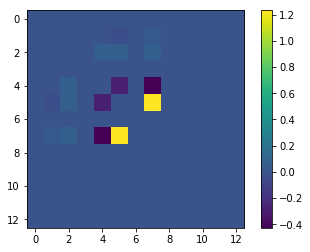

In [164]:
plt.imshow(shap_interaction_values[0] / 2)
plt.colorbar()

In [135]:
svb,svb.sum()

(array([[  0.        ,   0.01854849,   0.11632729,   0.        ,
          -0.55371079,   1.17269391,   0.        , -10.69165278,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ]]), -9.937793888855595)

In [130]:
e = shap.TreeExplainer(model, np.zeros((1,X.shape[1])), feature_dependence="independent")
tmp = e.shap_values(X.values[0:1,:])
tmp,tmp.sum()

(array([[  0.        ,   0.01854849,   0.11632749,   0.        ,
          -0.55370979,   1.17269363,   0.        , -10.69165233,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ]]), -9.937792513519526)

In [132]:
e = shap.KernelExplainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), np.zeros((1,X.shape[1])))
tmp = e.shap_values(X.values[0:1,:], nsamples=100000)
tmp,tmp.sum()

(array([[  0.        ,   0.01854849,   0.11632729,   0.        ,
          -0.55371078,   1.17269389,   0.        , -10.69165262,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ]]), -9.937793731689418)

In [65]:
set(list(powerset(range(4)))[3]).difference([3])

{2}

In [416]:
inds = np.where((X.values[:,5] > 5.8) & (X.values[:,5] < 6))[0]
inds = np.arange(3)

In [417]:
import numpy as np
from tqdm import tqdm
M = X.shape[1]
N = len(inds)
shap_interaction_values = np.zeros((N,M,M))
shap_values = np.zeros((N,M))
b = np.zeros((1,M))
ex_off = shap.TreeExplainer(model, b, feature_dependence="independent")
for i,sample_ind in enumerate(tqdm(inds)):#range(N)):
    x = X.values[sample_ind:sample_ind+1,:]
    for find in range(M):
        b_tmp = b.copy()
        b_tmp[0,find] = x[0,find]
        ex_on = shap.TreeExplainer(model, b_tmp, feature_dependence="independent")
        sv_on = ex_on.shap_values(x)

        x_tmp = x.copy()
        x_tmp[0,find] = b[0,find]
        sv_off = ex_off.shap_values(x_tmp)

        shap_interaction_values[i, find, :] = sv_on - sv_off
    
    shap_values[i] = ex_off.shap_values(x)



  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:00<00:01,  1.17it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.17it/s]

100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

In [418]:
shap_interaction_values[2,5,:].sum()

11.521523524075747

In [420]:
shap_values[2,5]

0.7731823921203613

In [420]:
x - y = 11.52

0.7731823921203613

In [420]:
x - y = 11.52

0.7731823921203613

In [423]:
shap_values[2,5] - svb_int_mobius[0,5,:].sum()/2

-4.971191088358562

In [426]:
svb_int_comobius[0,5,:].sum()/2 + shap_values[2,5]

6.550331433614095

In [434]:
shap_values[2,5] - svb_int[0,5,:].sum()*2

-10.748340420483146

In [433]:
svb_int[0,5,:] - (svb_int_mobius[0,5,:]/2 + svb_int_comobius[0,5,:]/2)/2

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.43623316e-09,  1.27629997e-07,
       -9.85892257e-10,  0.00000000e+00,  0.00000000e+00,  1.62350868e-08,
        0.00000000e+00])

[<matplotlib.lines.Line2D at 0x1c1f52ed68>]

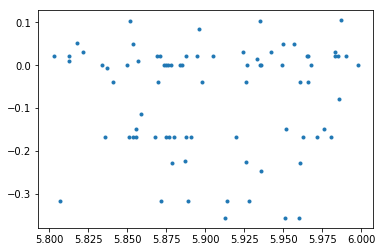

In [409]:
me = shap_values - shap_interaction_values.sum(2)
pl.plot(X.values[inds,5], me[:,5], ".")

[<matplotlib.lines.Line2D at 0x1c20bfc6d8>]

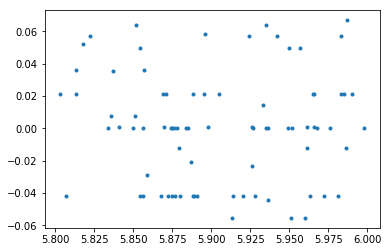

In [410]:
me = shap_values - shap_interaction_values[:,:,:].sum(2) / 2
pl.plot(X.values[inds,5], me[:,5], ".")

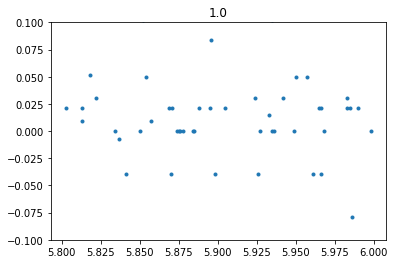

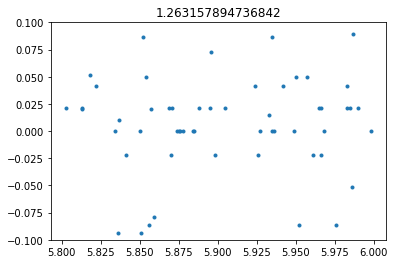

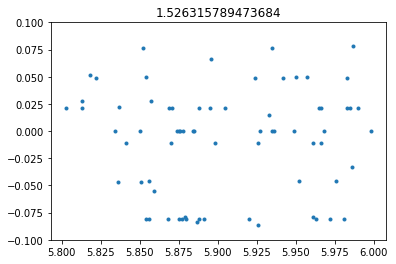

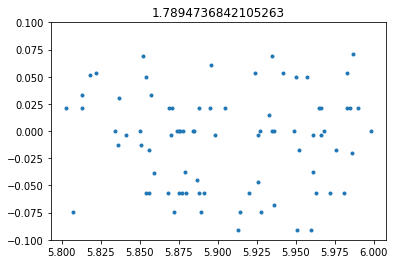

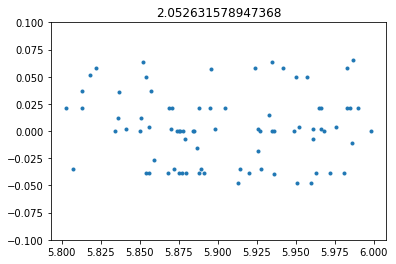

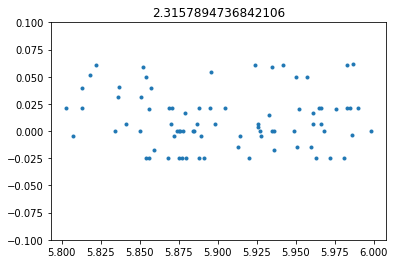

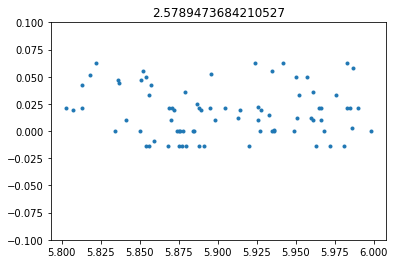

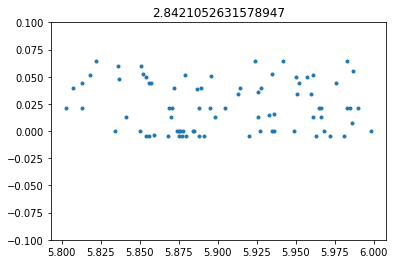

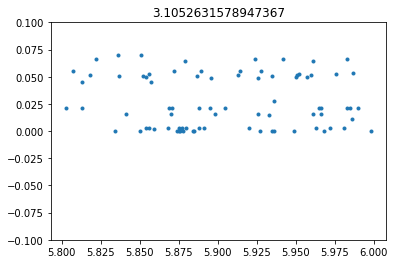

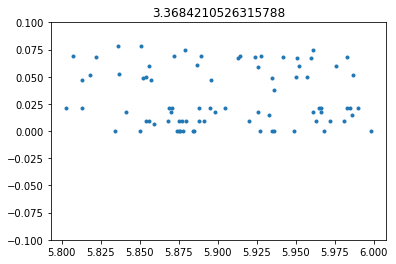

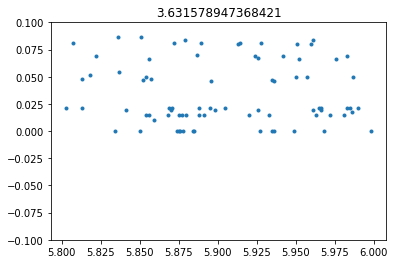

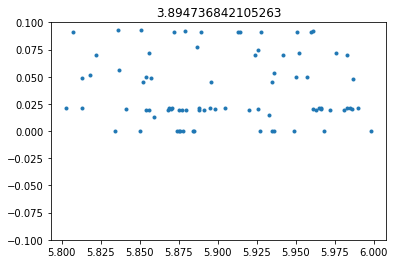

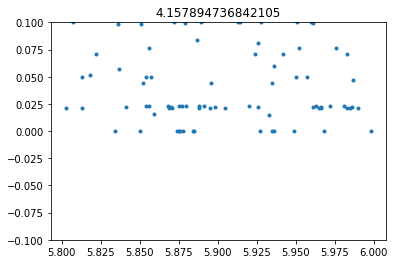

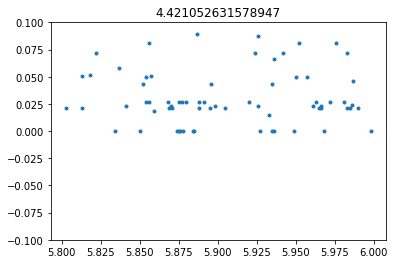

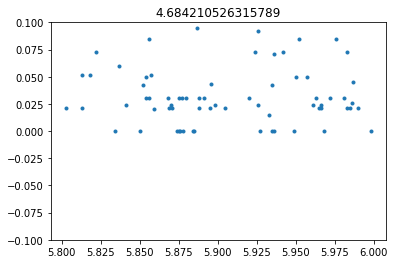

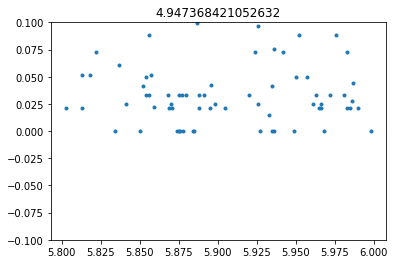

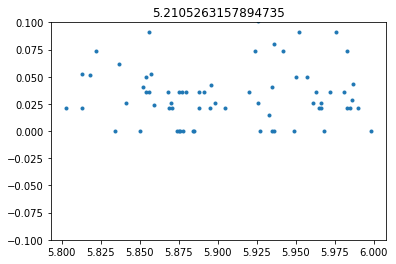

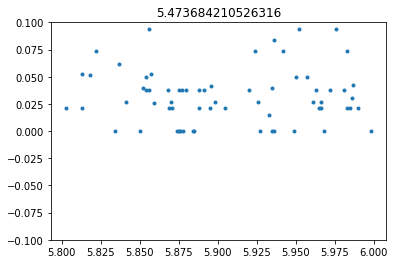

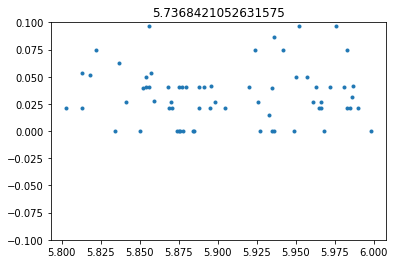

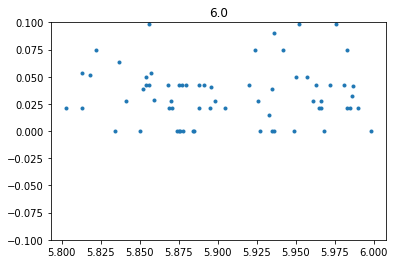

In [415]:
for tmp in np.linspace(1, 6, 20):
    me = shap_values - shap_interaction_values[:,:,:].sum(2) / tmp
    pl.title(tmp)
    pl.plot(X.values[inds,5], me[:,5], ".")
    pl.ylim(-0.1,0.1)
    pl.show()

In [365]:
shap_interaction_values[2,5,:].sum()

11.521523524075747

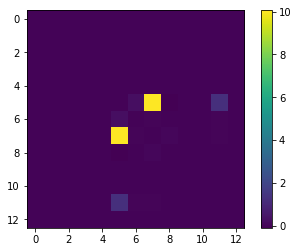

In [33]:
import matplotlib.pyplot as plt

plt.imshow(shap_interaction_values[2])
plt.colorbar()

In [36]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

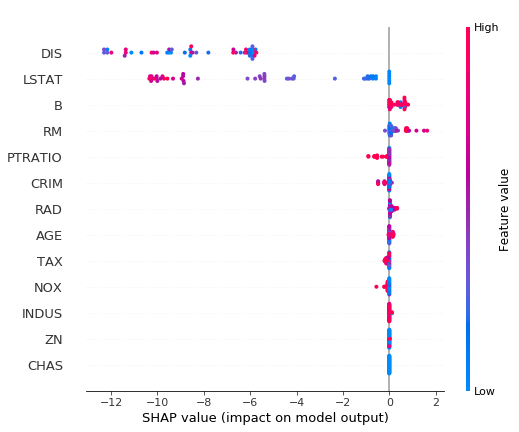

In [34]:
shap.summary_plot(shap_values, X.iloc[:50])

(array([1.160e+02, 8.202e+03, 5.200e+01, 6.000e+00, 1.000e+01, 1.000e+01,
        6.000e+00, 0.000e+00, 8.000e+00, 4.000e+01]),
 array([-1.61971848, -0.26857397,  1.08257053,  2.43371503,  3.78485953,
         5.13600403,  6.48714854,  7.83829304,  9.18943754, 10.54058204,
        11.89172655]),
 <a list of 10 Patch objects>)

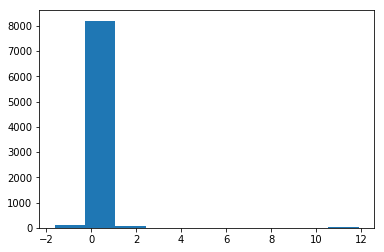

In [20]:
plt.hist(shap_interaction_values.flatten())

(array([10.,  4.,  9., 16.,  3.,  2.,  1.,  1.,  0.,  4.]),
 array([ 9.366862 , 10.572661 , 11.7784605, 12.98426  , 14.190059 ,
        15.395857 , 16.601656 , 17.807455 , 19.013254 , 20.219053 ,
        21.424852 ], dtype=float32),
 <a list of 10 Patch objects>)

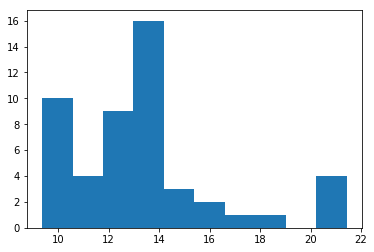

In [29]:
plt.hist(model.predict(xgboost.DMatrix(X.values[:50]), validate_features=False))

In [16]:
me = (shap_values - 0.5*shap_interaction_values.sum(2))

In [16]:
me = (shap_values - 0.5*shap_interaction_values.sum(2))

[<matplotlib.lines.Line2D at 0x1c1caf2668>]

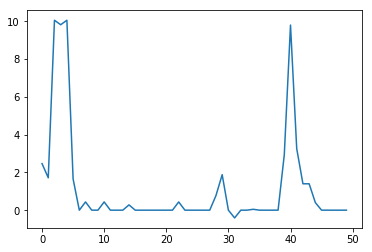

In [42]:
plt.plot(shap_interaction_values[:,5,7])

In [19]:
shap_values.shape

(50, 13)

In [16]:
me = (shap_values - 0.5*shap_interaction_values.sum(2))

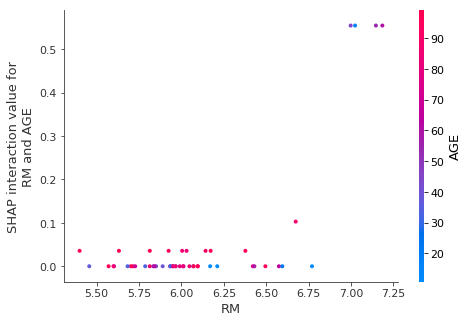

In [38]:
shap.dependence_plot(("RM", "AGE"), shap_interaction_values, X.iloc[:50])

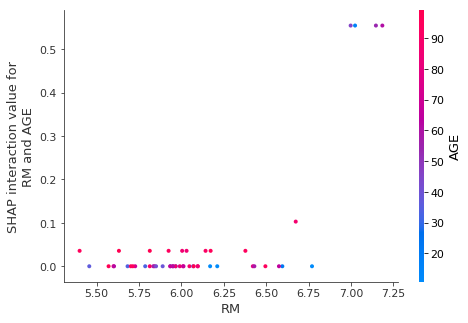

In [39]:
shap.dependence_plot((5, 6), shap_interaction_values, X.iloc[:50])

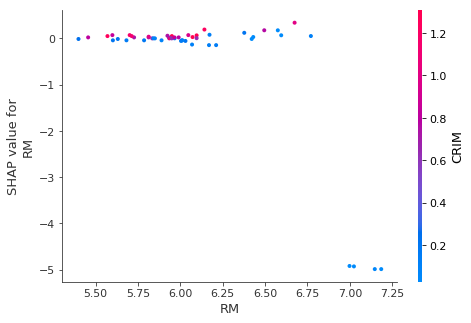

In [17]:
shap.dependence_plot(5, me, X.iloc[:50])

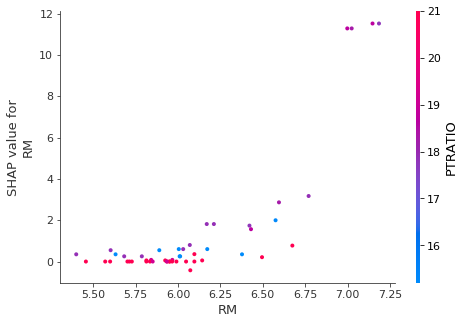

In [21]:
shap.dependence_plot(5, shap_interaction_values.sum(2), X.iloc[:50])

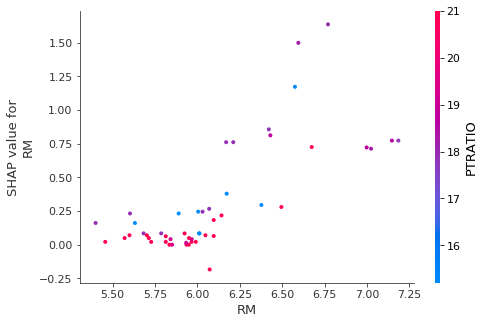

In [18]:
shap.dependence_plot(5, shap_values, X.iloc[:50])

In [23]:
sv_on

array([[  0.        ,   0.01854849,   0.11632749,   0.        ,
         -0.55370979,   1.17269363,   0.        , -10.69165233,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ]])

In [24]:
sv_off

array([[  0.        ,   0.01854849,   0.11632749,   0.        ,
         -0.55370979,   1.17269363,   0.        , -10.69165233,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ]])

In [3]:
shap_values = explainer.shap_interaction_values(X)

AssertionError: Only feature_dependence = "tree_path_dependent" is supported for SHAP interaction values right now!

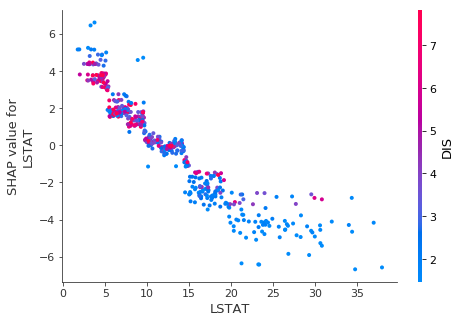

In [2]:
shap.dependence_plot("rank(0)", shap_values, X)

In [5]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train, X_test, Y_train, Y_test = train_test_split(*shap.datasets.iris(), test_size=0.1, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, nsamples=100, link="logit")
shap_values = explainer.shap_values(X_test, l1_reg="num_features(3)")

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0, :], X_test.iloc[0, :], link="logit")

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
Using 135 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [16]:
import numpy as np
import sklearn
import shap
import xgboost
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train, X_test, Y_train, Y_test = train_test_split(*shap.datasets.cric(), test_size=0.1, random_state=0)
model = xgboost.XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.02)
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.02,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [66]:
vs = np.abs(model.predict_proba(X_train)[:,1] - 0.95)
inds = np.argsort(vs)#[:200]
inds = inds[:200]

[<matplotlib.lines.Line2D at 0x1c2bce7f60>]

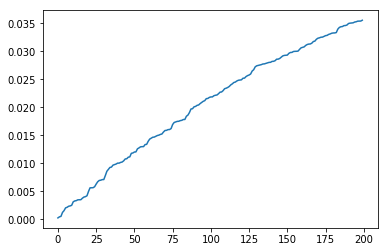

In [67]:
pl.plot(vs[inds])

In [80]:
import matplotlib.pyplot as pl
import scipy.cluster
import scipy as sp

In [81]:
data_subsample = X_train.iloc[inds,:]
D = sp.spatial.distance.pdist(X_train.fillna(X_train.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

ValueError: The condensed distance matrix must contain only finite values.

In [72]:
# use Independent SHAP to explain test set predictions
#data_subsample = sklearn.utils.resample(X_train, replace=False, n_samples=200, random_state=0)
explainer = shap.TreeExplainer(model, data_subsample, feature_dependence="independent", model_output="probability")

In [83]:
# use Independent SHAP to explain test set predictions
#data_subsample = sklearn.utils.resample(X_train, replace=False, n_samples=200, random_state=0)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [90]:
np.abs(shap_values.sum(1) + explainer.expected_value - model.predict(X_test, output_margin=True)).max()

2.0980835e-05

In [91]:
shap_int_values = explainer.shap_interaction_values(X_test.iloc[:10])

In [92]:
shap_int_values.shape

(10, 333, 333)

In [97]:
shap_values[0] - shap_int_values[0].sum(1)

array([-4.6566129e-10,  0.0000000e+00,  0.0000000e+00, -5.5879354e-09,
        4.6566129e-10, -1.4901161e-08, -3.7252903e-09,  7.4505806e-09,
       -3.7252903e-09,  0.0000000e+00, -8.9406967e-08,  5.5879354e-09,
        0.0000000e+00,  0.0000000e+00, -2.9103830e-11,  0.0000000e+00,
        0.0000000e+00, -2.3283064e-10, -1.8626451e-09,  2.3283064e-10,
        0.0000000e+00,  0.0000000e+00,  3.7252903e-09,  1.4551915e-11,
        1.4901161e-08,  7.2759576e-12, -7.4505806e-09, -1.1175871e-08,
        1.8626451e-08,  1.8626451e-09,  6.0535967e-09,  1.8626451e-09,
       -3.7252903e-08,  0.0000000e+00, -9.3132257e-10,  2.9802322e-08,
        3.4924597e-10,  3.7252903e-09, -7.4505806e-09,  0.0000000e+00,
        7.4505806e-08, -4.6566129e-10,  0.0000000e+00, -2.9802322e-08,
        0.0000000e+00, -7.4505806e-09,  0.0000000e+00, -2.9802322e-08,
        0.0000000e+00,  1.8626451e-09,  0.0000000e+00, -9.3132257e-10,
        0.0000000e+00,  0.0000000e+00,  1.3969839e-09,  0.0000000e+00,
      

In [90]:
np.abs(shap_values.sum(1) + explainer.expected_value - model.predict(X_test, output_margin=True)).max()

2.0980835e-05

In [88]:
?model.predict

In [42]:
# use Independent SHAP to explain test set predictions
#data_subsample = sklearn.utils.resample(X_train, replace=False, n_samples=200, random_state=0)
explainer = shap.PartitionExplainer(model, data_subsample)

In [50]:
model.predict_proba(X_train)[:,1].mean()

0.24728356

In [73]:
model.predict_proba(data_subsample)[:,1].mean()

0.9689551

In [29]:
import time

In [75]:
start = time.time()
shap_values = explainer.shap_values(X_test.iloc[:100,:])
(time.time() - start) / 100

0.05745361804962158

In [43]:
start = time.time()
explainer.shap_values(X_test.iloc[:100,:])
(time.time() - start) / 100

0.0031336712837219238

In [77]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [43]:
start = time.time()
explainer.shap_values(X_test.iloc[:100,:])
(time.time() - start) / 100

0.0031336712837219238

In [2]:
import shap

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
shap.plots.colors.red_blue

In [6]:
import numpy as np
import scipy as sp

In [11]:
p1 = 0.2
p2 = 1 - p1
lo = np.log(p1/p2)
sp.special.expit(lo)

0.2

In [ ]:
E[f(x) | x_1 = 1] - E[f(x) | x_1 = 0]

In [9]:
lo

-1.3862943611198906

In [4]:
?shap.KernelExplainer